El objetivo de este notebook es hacer una implementación rápida de GBM y ganar intuición sobre la forma de tomar las decisiones.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Mounted at /content/drive
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


In [2]:
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.1/663.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.6/281.6 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 59.6 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


In [3]:
import numpy as np
import joblib
import sys
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from comet_ml import Experiment
from lightgbm import LGBMClassifier

In [ ]:
# Importar los datos
features = joblib.load("/content/drive/My Drive/repo_tesis/src/datos_definitivos/FEATURES_W200_I50.joblib")
label = joblib.load("/content/drive/My Drive/repo_tesis/src/datos_definitivos/label_W200_I50.joblib")

features_array = np.array(features)
label_array = np.array(label)

In [ ]:
# %cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

# folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(2) + '.pkl')
# sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(2) + '.pkl')

# print(folds_ind)
# print(sujetos_array)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest
[array([ 5558,  5559,  5560, ..., 12118, 12119, 12120]), array([   0,    1,    2, ..., 5555, 5556, 5557]), array([12121, 12122, 12123, ..., 17671, 17672, 17673]), array([17674, 17675, 17676, ..., 24621, 24622, 24623]), array([24624, 24625, 24626, ..., 31115, 31116, 31117]), array([31118, 31119, 31120, ..., 37990, 37991, 37992]), array([37993, 37994, 37995, ..., 44782, 44783, 44784]), array([44785, 44786, 44787, ..., 51319, 51320, 51321]), array([51322, 51323, 51324, ..., 57842, 57843, 57844]), array([57845, 57846, 57847, ..., 64523, 64524, 64525])]
[1, 0, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

full_pipeline = Pipeline([
    ('gbm_classifier', LGBMClassifier(random_state=42))
])


grilla_n_estimators = [5, 50, 75, 100, 500]

metricas_grilla = []
modelos_grilla = []

# busqueda de hiperparametros mediante validacion cruzada
for k in range(len(grilla_n_estimators)):
  metricas = []
  modelos = []
  for i in range(0, 1): # aca decido qué sujeto va para test
    # Importo particiones
    folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl') # lista de listas. en cada elemento tengo la lista de indices de un fold
    sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl')   # lista con todos los sujetos, donde el primero corresponde al de test

    # por el criterio elegido, se que el primer fold es para test, asi que lo saco
    fold_test = folds_ind[0]

    # ahora lo quito para no armar entrevero
    folds_ind = folds_ind[1:]
    sujetos_CV = sujetos_array[1:]   # me quedo solo con los sujetos que voy usar para hacer CV
    # voy a hacer cross validation a mano
    # defino los folds que tengo, voy a ir dejando en validacion de a 1
    num_folds = np.arange(0, 9)   # no importa que no coincida con el sujeto, es solo para recorrer cada fold, al final me puedo fijar a qué sujeto pertenecía

    precision_train = []
    accuracy_train = []
    recall_train = []
    precision_val = []
    accuracy_val = []
    recall_val = []
    guardar_modelos = []

    for ind_fold_val in num_folds:  # voy tomando los folds de validacion en orden segun folds_ind, es decir sujetos_array
      folds_ind_train = folds_ind.copy()
      folds_ind_train.pop(ind_fold_val)
      fold_ind_val = folds_ind[ind_fold_val]

      # concateno los arrays en uno solo
      folds_ind_train_array = np.concatenate(folds_ind_train)

      # aplanar el array resultante
      folds_ind_train_array = folds_ind_train_array.ravel()

      # concateno los arrays en uno solo
      fold_ind_val_array = np.array(fold_ind_val)

      # Defino X_train, y_train, X_val, y_val
      X_train = features_array[folds_ind_train_array, :]
      y_train = label_array[folds_ind_train_array, 1]

      X_val = features_array[fold_ind_val_array, :]
      y_val = label_array[fold_ind_val_array, 1]

      # ajusto el modelo con los datos de entrenamiento
      # modelo = DecisionTreeClassifier(max_depth=grilla_max_depth[k])
      # Configurar el parámetro en el clasificador dentro del pipeline
      full_pipeline.set_params(gbm_classifier__n_estimators=grilla_n_estimators[k])
      full_pipeline.fit(X_train, y_train)

      # calculo las predicciones sobre los datos de train y val
      y_pred_train = full_pipeline.predict(X_train)
      y_pred_val = full_pipeline.predict(X_val)

      # calculo metricas sobre conjunto de train y val
      precision_train.append(precision_score(y_train, y_pred_train, average='weighted'))
      precision_val.append(precision_score(y_val, y_pred_val, average='weighted'))
      accuracy_train.append(accuracy_score(y_train, y_pred_train))
      accuracy_val.append(accuracy_score(y_val, y_pred_val))
      recall_train.append(recall_score(y_train, y_pred_train, average='weighted'))
      recall_val.append(recall_score(y_val, y_pred_val, average='weighted'))
      guardar_modelos.append(full_pipeline)

        # Crear DataFrame
    data = {'Fold_val': sujetos_CV,
            'precision_train': precision_train,
            'precision_val': precision_val,
            'accuracy_train': accuracy_train,
            'accuracy_val': accuracy_val,
            'recall_train': recall_train,
            'recall_val': recall_val}

    df = pd.DataFrame(data)

    # para un valor del hiperparametro, guardo las metricas y modelos de los sujetos
    metricas.append(df)
    modelos.append(guardar_modelos)
  metricas_grilla.append(metricas)
  modelos_grilla.append(modelos)

joblib.dump(metricas_grilla, 'metricas_grilla_gbm_n_estimators2.pkl')
joblib.dump(modelos_grilla, 'modelos_grilla_gbm_n_estimators2.pkl')

'''
por cada sujeto que mando a test, tengo un dataFrame de metricas, donde cada fila corresponde a una iteracion de CV (usando un fold
de validacion distinto)
'''


/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50349
[LightGBM] [Info] Number of data points in the train set: 52405, number of used features: 240
[LightGBM] [Info] Start training from score -2.564988
[LightGBM] [Info] Start training from score -2.610410
[LightGBM] [Info] Start training from score -2.622161
[LightGBM] [Info] Start training from score -2.600336
[LightGBM] [Info] Start training from score -2.584527
[LightGBM] [Info] Start training from score -2.556588
[LightGBM] [Info] Start training from score -2.556834
[LightGBM] [Info] Start training from score -2.558805
[LightGBM] [Info] Start training from score -2.563748
[LightGBM] [Info] Start training from score -2.611189
[LightGBM] [Info] Start training from score -2.272973
[LightGBM] [Info] Start training f

'\npor cada sujeto que mando a test, tengo un dataFrame de metricas, donde cada fila corresponde a una iteracion de CV (usando un fold\nde validacion distinto)\n'

In [ ]:
df.head(10)

,Fold_val,precision_train,precision_val,accuracy_train,accuracy_val,recall_train,recall_val
0,1,0.757858,0.402991,0.742963,0.379857,0.742963,0.379857
1,2,0.758149,0.385199,0.742900,0.343058,0.742900,0.343058
2,3,0.767054,0.417124,0.752047,0.390647,0.752047,0.390647
3,4,0.764889,0.405037,0.748523,0.369110,0.748523,0.369110
4,5,0.770789,0.237120,0.756628,0.241600,0.756628,0.241600
5,6,0.763107,0.266875,0.749598,0.286072,0.749598,0.286072
6,7,0.762986,0.344451,0.748241,0.319566,0.748241,0.319566
7,8,0.760903,0.375490,0.745581,0.342634,0.745581,0.342634
8,9,0.763941,0.272919,0.747299,0.269121,0.747299,0.269121


In [10]:
# Acceder a las metricas y modelos si los tengo guardados en un pkl
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/hello_world/resultados_preliminares"

metricas_grilla = joblib.load("metricas_grilla_gbm_n_estimators2.pkl")
modelos_grilla = joblib.load("modelos_grilla_gbm_n_estimators2.pkl")

# metricas_grilla = joblib.load("HW_NP_GBM_sep_sub_CV_1test_metricas.pkl")
# modelos_grilla = joblib.load("HW_NP_GBM_sep_sub_CV_1test.pkl")

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/hello_world/resultados_preliminares


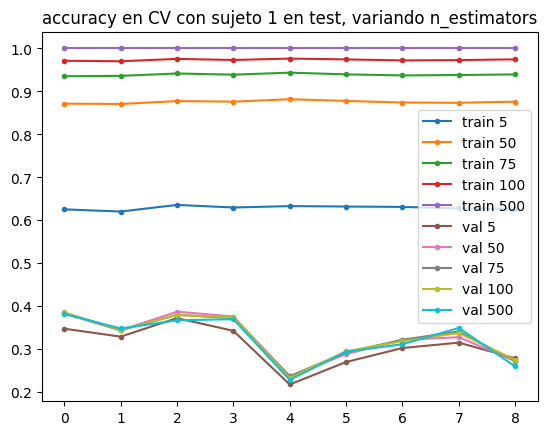

In [13]:
# el primer argumento controla la posicion de la grilla de hiperparametro
# el segundo controla el sujeto que miro
# metricas_grilla[3][0].accuracy_train # hiperparametro posicion 3, sujeto posicion 0 (sujeto 1)

i = 0   # elijo el sujeto que saco para test
# Voy a graficar accuracy para las diferentes metricas
plt.figure()
plt.title('accuracy en CV con sujeto ' + str(i+1) + ' en test, variando n_estimators')
plt.plot(metricas_grilla[0][i].accuracy_train, '.-')
plt.plot(metricas_grilla[1][i].accuracy_train, '.-')
plt.plot(metricas_grilla[2][i].accuracy_train, '.-')
plt.plot(metricas_grilla[3][i].accuracy_train, '.-')
plt.plot(metricas_grilla[4][i].accuracy_train, '.-')

plt.plot(metricas_grilla[0][i].accuracy_val, '.-')
plt.plot(metricas_grilla[1][i].accuracy_val, '.-')
plt.plot(metricas_grilla[2][i].accuracy_val, '.-')
plt.plot(metricas_grilla[3][i].accuracy_val, '.-')
plt.plot(metricas_grilla[4][i].accuracy_val, '.-')

plt.legend(['train 5', 'train 50', 'train 75', 'train 100', 'train 500', 'val 5', 'val 50', 'val 75', 'val 100', 'val 500'])


In [8]:
a = metricas_grilla

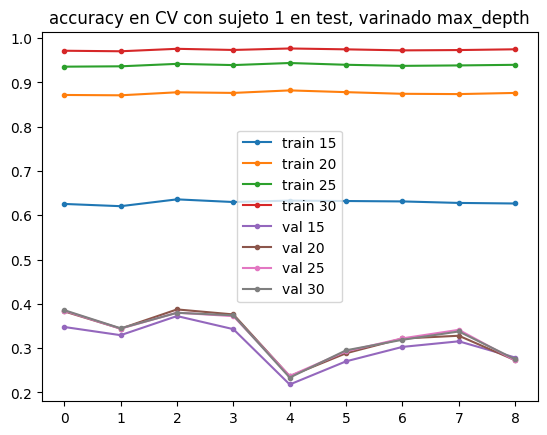

In [14]:
# el primer argumento controla la posicion de la grilla de hiperparametro
# el segundo controla el sujeto que miro
# metricas_grilla[3][0].accuracy_train # hiperparametro posicion 3, sujeto posicion 0 (sujeto 1)

i = 0   # elijo el sujeto que saco para test
# Voy a graficar accuracy para las diferentes metricas
plt.figure()
plt.title('accuracy en CV con sujeto ' + str(i+1) + ' en test, varinado max_depth')
plt.plot(metricas_grilla[0][i].accuracy_train, '.-')
plt.plot(metricas_grilla[1][i].accuracy_train, '.-')
plt.plot(metricas_grilla[2][i].accuracy_train, '.-')
plt.plot(metricas_grilla[3][i].accuracy_train, '.-')

plt.plot(metricas_grilla[0][i].accuracy_val, '.-')
plt.plot(metricas_grilla[1][i].accuracy_val, '.-')
plt.plot(metricas_grilla[2][i].accuracy_val, '.-')
plt.plot(metricas_grilla[3][i].accuracy_val, '.-')

plt.legend(['train 15', 'train 20', 'train 25', 'train 30', 'val 15', 'val 20', 'val 25', 'val 30'])

# la mejor opcion parece max_depth=10

In [ ]:
params_opt = [30, 20, 20, 30, 30, 30, 30, 30, 30, 30]

In [ ]:
folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(1) + '.pkl')
sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(2) + '.pkl')

print(folds_ind)

[array([], dtype=int64), array([   0,    1,    2, ..., 5555, 5556, 5557]), array([ 5558,  5559,  5560, ..., 12118, 12119, 12120]), array([12121, 12122, 12123, ..., 17671, 17672, 17673]), array([17674, 17675, 17676, ..., 24621, 24622, 24623]), array([24624, 24625, 24626, ..., 31115, 31116, 31117]), array([31118, 31119, 31120, ..., 37990, 37991, 37992]), array([37993, 37994, 37995, ..., 44782, 44783, 44784]), array([44785, 44786, 44787, ..., 51319, 51320, 51321]), array([51322, 51323, 51324, ..., 57842, 57843, 57844])]


In [ ]:
grilla_max_depth = [15, 20, 25, 30]
sujetos_array_lista = []
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"
for i in range(0, 10): # aca decido qué sujeto va para test
  # Importo particiones
  sujetos_array_lista.append(joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl'))   # lista con todos los sujetos, donde el primero corresponde al de test

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


In [ ]:
nombre = 'HW_NP_GBM_sep_sub_CV_1test'

joblib.dump(modelos_grilla, nombre + '.pkl')
joblib.dump(metricas_grilla, nombre + '_metricas.pkl')

API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
                project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['HelloWorld', 'GBM', 'sep_sub', 'choose_test', 'gridSearch', 'CV']) # Tags

exp.log_parameter("particion_sujetos", sujetos_array_lista)   # Guarda el arreglo en el experimento
exp.log_parameter("param_grid", grilla_max_depth)   # Guarda el arreglo en el experimento
exp.log_parameter("hiperparameter_name", 'max_depth')   # Guarda el arreglo en el experimento
exp.log_text("Se fija el sujeto de test, para cada una de las 10 CV (de cada valor del hiperparámetro). Se hace una búsqueda del parámetro max_depth. El primer sujeto del arreglo de sujetos es el de test (para cada uno de los 10 experimentos, está en orden).")   # Comentario del experimento
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.log_model(name=nombre + '_metricas', file_or_folder=nombre + '_metricas.pkl')

exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/e4469b5e5e00464f8241e91adfe7fcfc

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : HW_NP_GBM_sep_sub_CV_1test
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/e4469b5e5e00464f8241e91adfe7fcfc
COMET INFO:   Others:
COMET INFO:     Name : HW_NP_GBM_sep_sub_CV_1test
COMET INFO:

# Entrenamiento y resultados en test

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

full_pipeline = Pipeline([
    ('gbm_classifier', LGBMClassifier(n_estimators=500, random_state=42))
])

precision_train = []
accuracy_train = []
recall_train = []
precision_test = []
accuracy_test = []
recall_test = []
guardar_modelos = []
sujetos_test = []
for i in range(0, 10):
  folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl') # lista de listas. en cada elemento tengo la lista de indices de un fold
  sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl')   # lista con todos los sujetos, donde el primero corresponde al de test
  sujetos_test.append(sujetos_array[0])
  # por el criterio elegido, se que el primer fold es para test, asi que lo saco
  fold_test = folds_ind[0]

  # ahora lo quito para no armar entrevero
  folds_ind = folds_ind[1:]

  # concateno los arrays de train_ind en uno solo
  folds_ind_train_array = np.concatenate(folds_ind)
  # aplanar el array resultante
  folds_ind_train_array = folds_ind_train_array.ravel()

  # Defino X_train, y_train, X_val, y_val
  X_train = features_array[folds_ind_train_array, :]
  y_train = label_array[folds_ind_train_array, 1]

  X_test = features_array[fold_test, :]
  y_test = label_array[fold_test, 1]

  full_pipeline.set_params(gbm_classifier__max_depth=params_opt[i])
  full_pipeline.fit(X_train, y_train)

  # calculo las predicciones sobre los datos de train y val
  y_pred_train = full_pipeline.predict(X_train)
  y_pred_test = full_pipeline.predict(X_test)

  # calculo metricas sobre conjunto de train y val
  precision_train.append(precision_score(y_train, y_pred_train, average='weighted'))
  precision_test.append(precision_score(y_test, y_pred_test, average='weighted'))
  accuracy_train.append(accuracy_score(y_train, y_pred_train))
  accuracy_test.append(accuracy_score(y_test, y_pred_test))
  recall_train.append(recall_score(y_train, y_pred_train, average='weighted'))
  recall_test.append(recall_score(y_test, y_pred_test, average='weighted'))
  guardar_modelos.append(full_pipeline)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.336981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50353
[LightGBM] [Info] Number of data points in the train set: 58968, number of used features: 240
[LightGBM] [Info] Start training from score -2.564949
[LightGBM] [Info] Start training from score -2.609812
[LightGBM] [Info] Start training from score -2.618380
[LightGBM] [Info] Start training from score -2.596300
[LightGBM] [Info] Start training from score -2.581398
[LightGBM] [Info] Start training from score -2.554641
[LightGBM] [Info] Start training from score 

In [ ]:
joblib.dump(guardar_modelos, 'gbm_HW_NP_10_sep_sub_max_depth_trainTest_modelos.pkl')

['gbm_HW_NP_10_sep_sub_max_depth_trainTest_modelos.pkl']

In [ ]:
# Crear DataFrame
data = {'sujeto_test': sujetos_test,
        'precision_train': precision_train,
        'precision_test': precision_test,
        'accuracy_train': accuracy_train,
        'accuracy_test': accuracy_test,
        'recall_train': recall_train,
        'recall_test': recall_test}
data = pd.DataFrame(data)
joblib.dump(data, 'gbm_HW_NP_10_sep_sub_max_depth_trainTest.pkl')

['gbm_HW_NP_10_sep_sub_max_depth_trainTest.pkl']

In [ ]:
data.head(10)

,sujeto_test,precision_train,precision_test,accuracy_train,accuracy_test,recall_train,recall_test
0,0,1.0,0.293205,1.0,0.274919,1.0,0.274919
1,1,1.0,0.412348,1.0,0.385037,1.0,0.385037
2,2,1.0,0.418415,1.0,0.357645,1.0,0.357645
3,3,1.0,0.417099,1.0,0.359281,1.0,0.359281
4,4,1.0,0.391083,1.0,0.369418,1.0,0.369418
5,5,1.0,0.243321,1.0,0.227927,1.0,0.227927
6,6,1.0,0.299536,1.0,0.297998,1.0,0.297998
7,7,1.0,0.330327,1.0,0.314364,1.0,0.314364
8,8,1.0,0.396547,1.0,0.344167,1.0,0.344167
9,9,1.0,0.224829,1.0,0.220177,1.0,0.220177


In [ ]:
# Acceder a las metricas y modelos si los tengo guardados en un pkl
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares"

metricas_grilla = joblib.load("HW_NP_GBM_sep_sub_10exp_1test_metricas.pkl")
modelos_grilla = joblib.load("HW_NP_GBM_sep_sub_10exp_1test.pkl")

params_opt = [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
print(metricas_grilla)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares
   sujeto_test  precision_train  precision_test  accuracy_train  \
0            0              1.0        0.293205             1.0   
1            1              1.0        0.412348             1.0   
2            2              1.0        0.418415             1.0   
3            3              1.0        0.417099             1.0   
4            4              1.0        0.391083             1.0   
5            5              1.0        0.243321             1.0   
6            6              1.0        0.299536             1.0   
7            7              1.0        0.330327             1.0   
8            8              1.0        0.396547             1.0   
9            9              1.0        0.224829             1.0   

   accuracy_test  recall_train  recall_test  
0       0.274919           1.0     0.274919  
1       0.385037           1.0     0.385037  
2       0.357645           1.0

In [ ]:
sujetos_array_lista = []
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"
for i in range(0, 10): # aca decido qué sujeto va para test
  # Importo particiones
  sujetos_array_lista.append(joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl'))   # lista con todos los sujetos, donde el primero corresponde al de test

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares"

nombre = 'HW_NP_GBM_sep_sub_10exp_1test'

joblib.dump(modelos_grilla, nombre + '.pkl')
joblib.dump(metricas_grilla, nombre + '_metricas.pkl')

API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
                project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['HelloWorld', 'GBM', 'sep_sub', 'choose_test']) # Tags

exp.log_parameter("particion_sujetos", sujetos_array_lista)   # Guarda el arreglo en el experimento
exp.log_parameter("hiparams_usados", params_opt)   # Guarda el arreglo en el experimento
exp.log_parameter("hiperparameter_name", 'max_depth, n_estimators=500, random_state=42')   # Guarda el arreglo en el experimento
exp.log_text("Se guardan los modelos y metricas de 10 experimentos. En cada uno se usa la partición de particion_sujetos y el hiperparametro de hiparams_usados. Se usó n_estimators=500 y random_state=42. Se fija el sujeto de test, siendo el primero del arreglo.")   # Comentario del experimento
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.log_model(name=nombre + '_metricas', file_or_folder=nombre + '_metricas.pkl')

exp.end()

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/91df0a2c0e9b4719be750953ca5dc81d

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : HW_NP_GBM_sep_sub_10exp_1test
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/91df0a2c0e9b4719be750953ca5dc81d
COMET INFO:   Others:
COMET INFO:     Name : HW_NP_GBM_sep_sub_10exp_1test
COMET

# Análisis de importancia de features

In [ ]:
# Acceder a las metricas y modelos si los tengo guardados en un pkl
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares"

metricas_grilla = joblib.load("HW_NP_GBM_sep_sub_10exp_1test_metricas.pkl")
modelos_grilla = joblib.load("HW_NP_GBM_sep_sub_10exp_1test.pkl")

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/holaMundo/resultados_preliminares


In [ ]:
metricas_grilla

,sujeto_test,precision_train,precision_test,accuracy_train,accuracy_test,recall_train,recall_test
0,0,1.0,0.293205,1.0,0.274919,1.0,0.274919
1,1,1.0,0.412348,1.0,0.385037,1.0,0.385037
2,2,1.0,0.418415,1.0,0.357645,1.0,0.357645
3,3,1.0,0.417099,1.0,0.359281,1.0,0.359281
4,4,1.0,0.391083,1.0,0.369418,1.0,0.369418
5,5,1.0,0.243321,1.0,0.227927,1.0,0.227927
6,6,1.0,0.299536,1.0,0.297998,1.0,0.297998
7,7,1.0,0.330327,1.0,0.314364,1.0,0.314364
8,8,1.0,0.396547,1.0,0.344167,1.0,0.344167
9,9,1.0,0.224829,1.0,0.220177,1.0,0.220177


In [ ]:
# elijo uno de los modelos para utilizar
i = 1

model = modelos_grilla[i]

model

Pipeline(steps=[('gbm_classifier',
                 LGBMClassifier(max_depth=30, n_estimators=500,
                                random_state=42))])

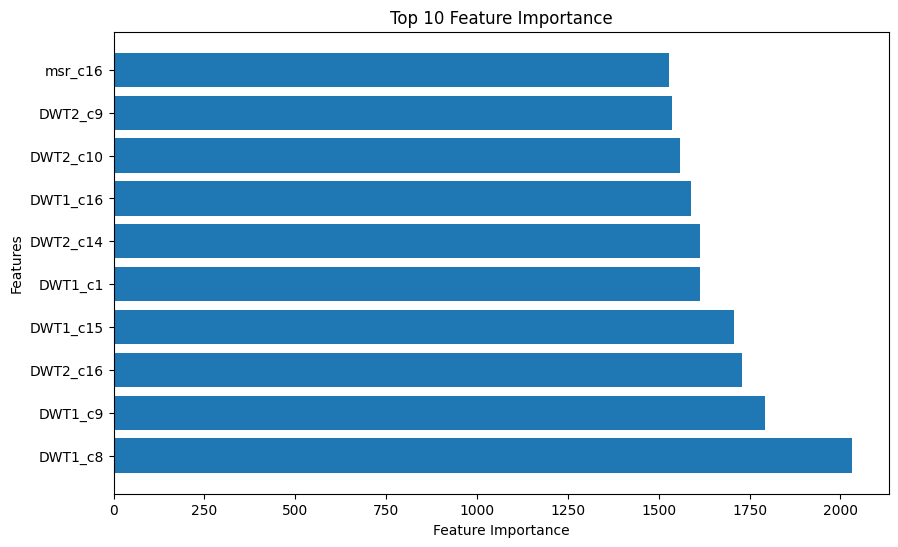

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Obtener los nombres de las columnas del DataFrame 'features'
feature_names = features.columns

# Acceder al modelo LGBMClassifier dentro del pipeline
lgbm_model = model.named_steps['gbm_classifier']

# Obtener los nombres de las columnas del DataFrame 'features'
feature_names = features.columns

# Obtener la importancia de las características
feature_importance = lgbm_model.feature_importances_
# Obtener las índices de las características más importantes
top_indices = feature_importance.argsort()[-10:][::-1]  # Tomar las 10 características más importantes

# Obtener los nombres de las características más importantes
top_feature_names = feature_names[top_indices]

# Obtener la importancia de las características más importantes
top_feature_importance = feature_importance[top_indices]

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_feature_names)), top_feature_importance, align='center')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importance')
plt.show()

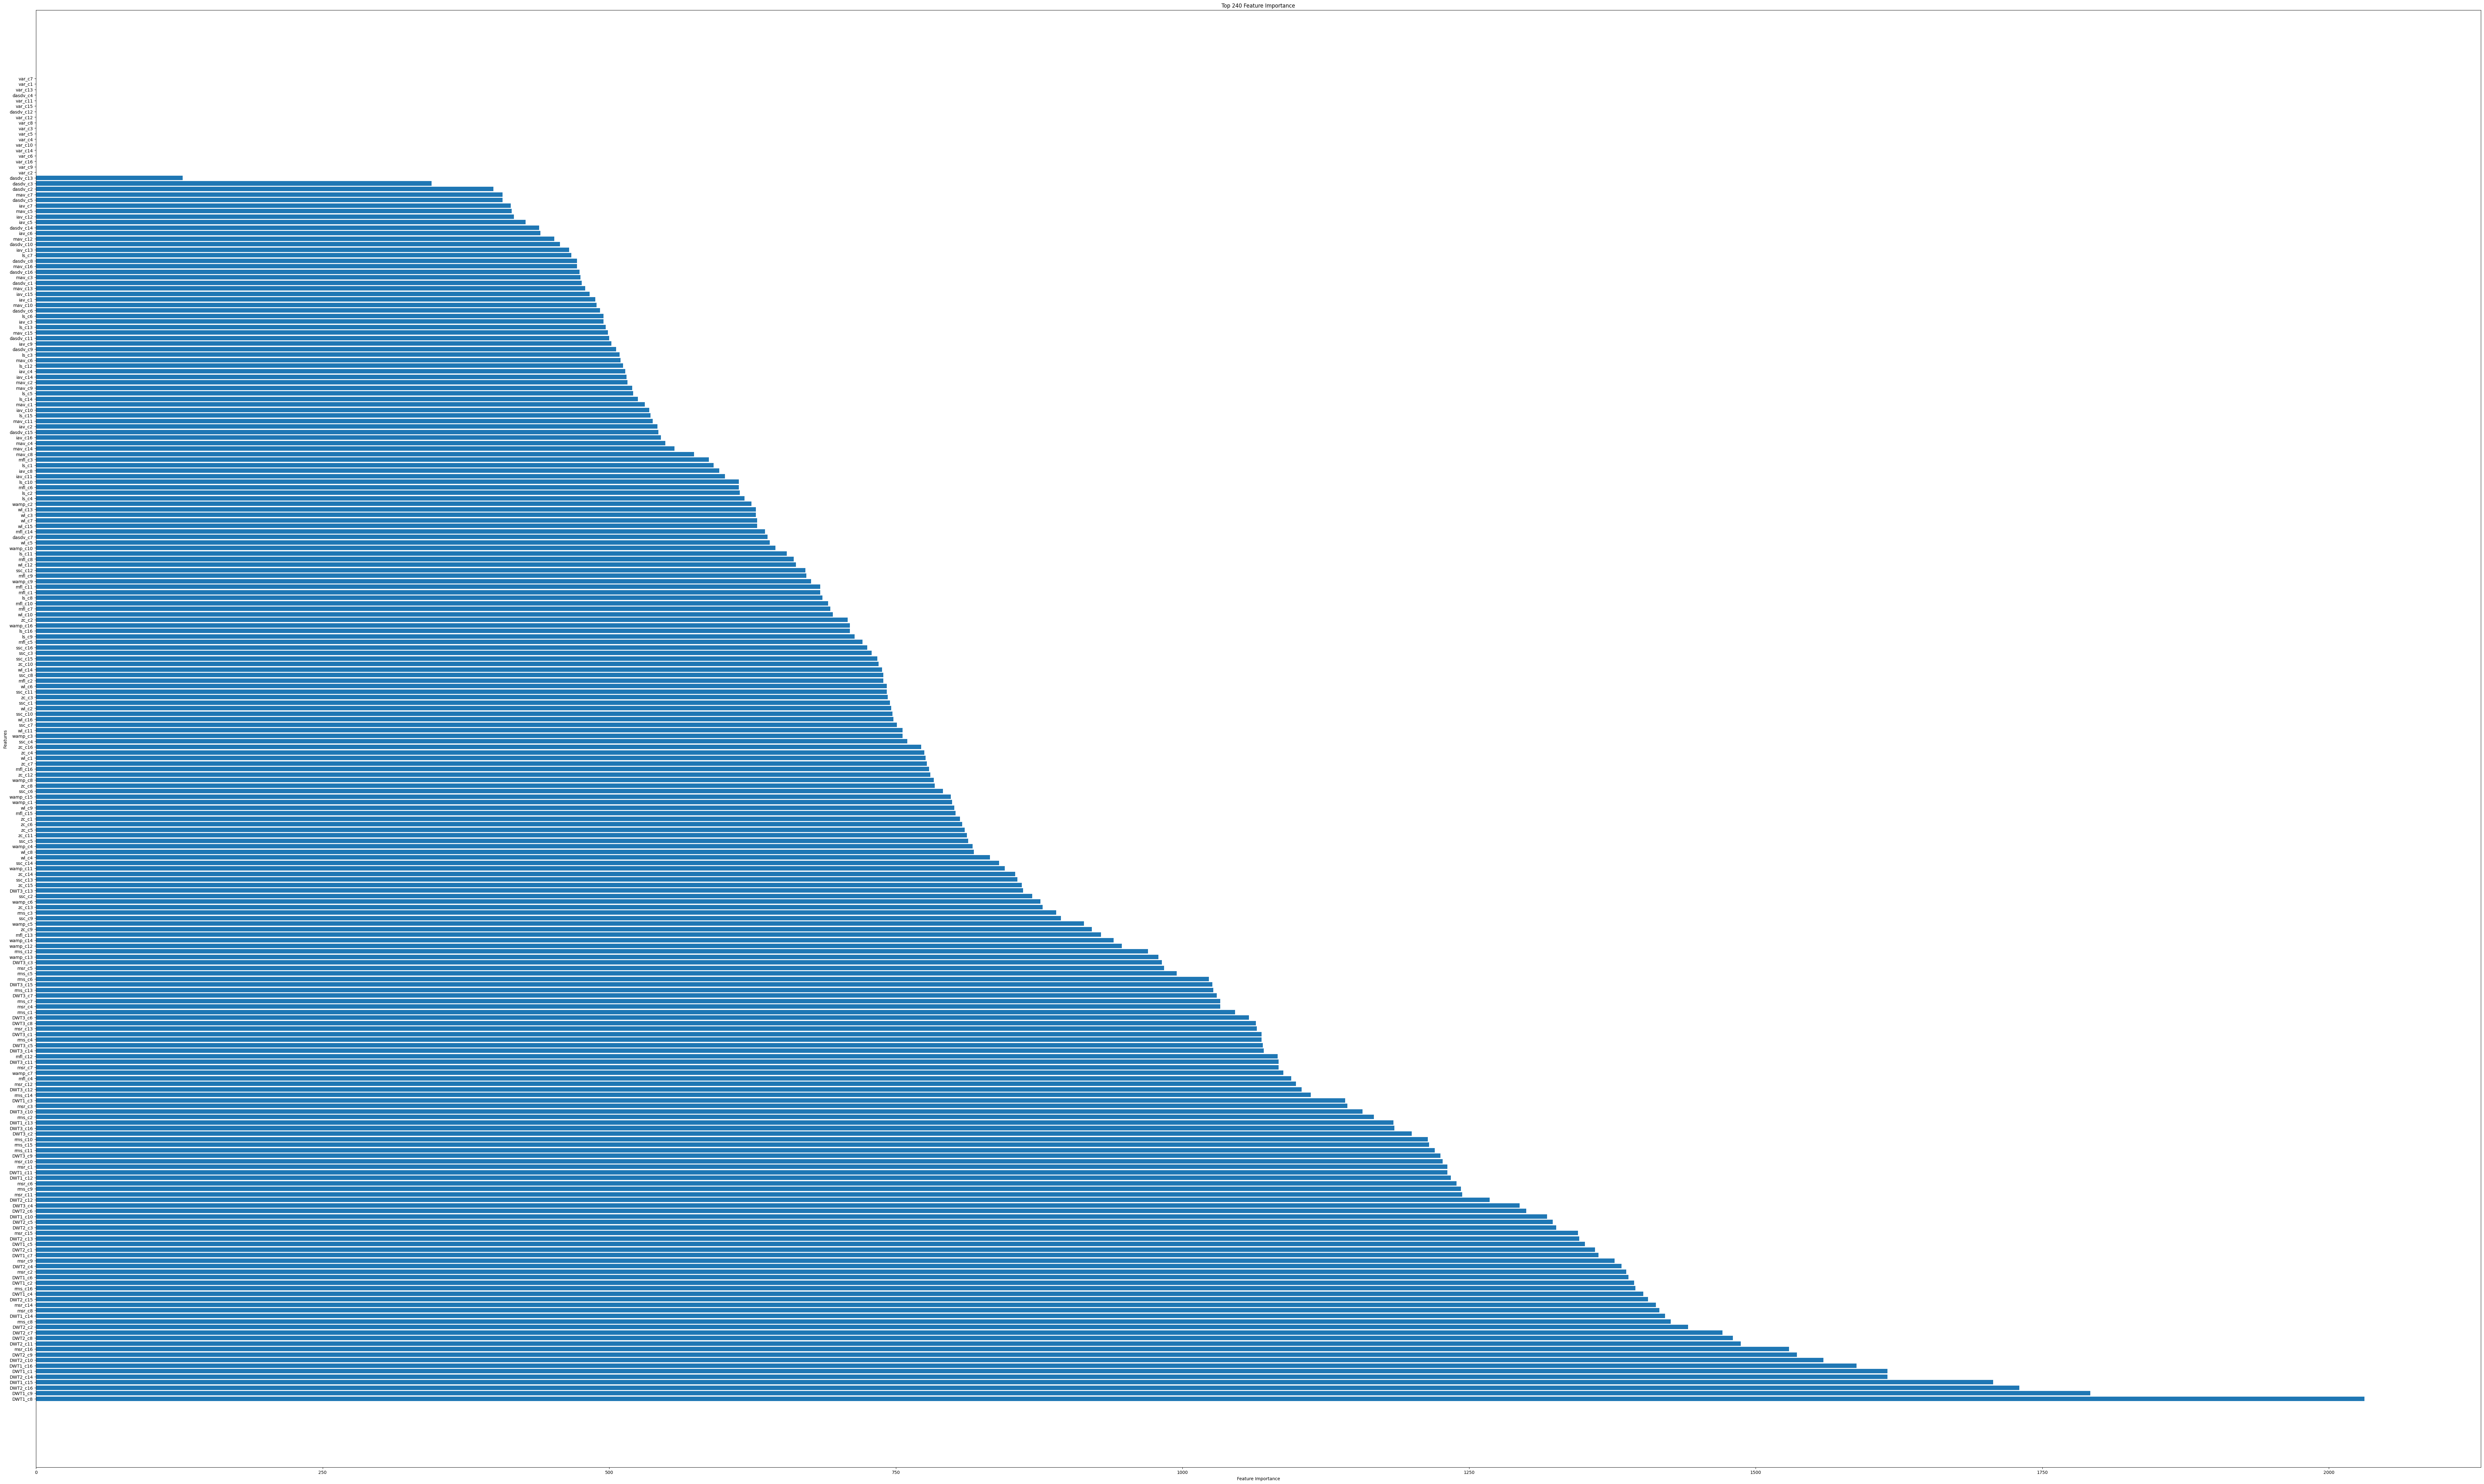

In [ ]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

def plot_feature_importance(features, pipeline, num_features=10):
    # Acceder al modelo LGBMClassifier dentro del pipeline
    lgbm_model = pipeline.named_steps['gbm_classifier']

    # Obtener los nombres de las columnas del DataFrame 'features'
    feature_names = features.columns

    # Obtener la importancia de las características
    feature_importance = lgbm_model.feature_importances_

    # Crear un DataFrame con los nombres y las importancias de las características
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Ordenar el DataFrame por importancia en orden descendente
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Tomar las 'num_features' características más importantes
    top_features = importance_df.head(num_features)

    # Visualizar la importancia de las características
    plt.figure(figsize=(100, 60))
    plt.barh(top_features['Feature'], top_features['Importance'], align='center')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Top {num_features} Feature Importance')
    plt.show()

# Llamar a la función con el número deseado de características a graficar
plot_feature_importance(features, model, num_features=240)  # Cambiar num_features según sea necesario


<Figure size 10000x6000 with 0 Axes>

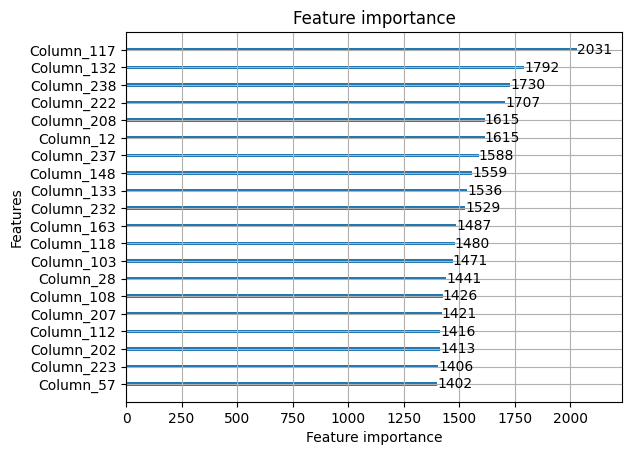

In [ ]:
# Calcular la importancia de las características
feature_importance = lgbm_model.feature_importances_

# Visualizar la importancia de las características
import matplotlib.pyplot as plt
plt.figure(figsize=(100, 60))
lgb.plot_importance(lgbm_model, max_num_features=20)
plt.show()

In [ ]:
feature_names[117]

'DWT1_c8'